In [1]:
from pathlib import Path
import os
import pandas as pd
import sys
import requests
from functools import partial
from tqdm import tqdm

import torch
import torchvision
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch 
from einops import rearrange, repeat
from loguru import logger
from torchmetrics import Metric, BootStrapper
import matplotlib.pyplot as plt
from PIL import Image
import pickle
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from cka import gram, centering_mat, centered_gram, unbiased_hsic_xy, MinibatchCKA, HookedCache, make_pairwise_metrics, update_metrics, get_simmat_from_metrics
import numpy as np
import re

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import timm
from timm.utils import accuracy
from torch.utils.tensorboard import SummaryWriter

from get_models import get_model

writer = SummaryWriter()

DEVICE = torch.device('cpu')
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')

/private/home/sshkhr/.conda/envs/pytorch_env/lib/python3.9/site-packages/MinkowskiEngine-0.5.4-py3.9-linux-x86_64.egg/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
import itertools

In [3]:
from ast import literal_eval

### Linear probes eval

In [35]:
resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}}
#datasets = ['Food101', 'FGVCAircraft']
#resultsp = {k:{d:{} for d in datasets} for k in resultsp.keys()}

for key in resultsp:
    folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/" #Food101/logs/" + key + '/vit_base_patch16/'

    log_files_list = []
    for root, dirs, files in os.walk(folder_name):
        if root[len(folder_name):].count(os.sep) < 10:
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)  
                    log_files_list.append(log_file)   

    for log_file in log_files_list:
        if key in log_file and 'Food101' in log_file:            
            log_list = []
            print(log_file)
            if os.path.isfile(log_file): 
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)
                    
            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            #print(log_file.split('/')[-4])
            try:
                if 'lin_' in log_file:
                    resultsp[key][log_file.split('/')[-3]][log_file.split('/')[-2]] = df
                else:
                    resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-2]] = df
            except KeyError:
                if 'lin_' in log_file:
                    resultsp[key][log_file.split('/')[-3]] = {}
                    resultsp[key][log_file.split('/')[-3]][log_file.split('/')[-2]] = df
                else:
                    resultsp[key][log_file.split('/')[-5]] = {}
                    resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-2]] = df

/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_1/12803865/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_1/12979637/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_1/12986750/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_2/12803866/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_2/12979664/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_2/12986751/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/logs/MAE/vit_base_patch16/lin_3/12803867/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/Food101/l

In [36]:
df= {}
df_all = {}
for model in resultsp:
    df[model] = {}
    df_all[model] = {}
    for intermediate in resultsp[model]:
        print(model, intermediate)
        top_1 = [resultsp[model][intermediate][exp]['test_acc1'].max() for exp in resultsp[model][intermediate]]
        best = sorted(top_1, reverse=True)[:5]
        if 'lin_' in intermediate:
            intermediate = int(intermediate.split('_')[1])
        df[model][intermediate] = np.mean(best)
        df_all[model][intermediate] = best

MAE lin_1
MAE lin_2
MAE lin_3
MAE lin_4
MAE blocks.0
MAE blocks.1
MAE blocks.2
MAE blocks.3
MAE blocks.4
MAE blocks.5
MAE blocks.6
MAE blocks.7
MAE blocks.8
MAE blocks.9
MAE blocks.10
MAE blocks.11
MAE all
MoCo lin_1
MoCo lin_2
MoCo lin_3
MoCo lin_4
MoCo blocks.2
MoCo blocks.3
MoCo blocks.4
MoCo blocks.5
MoCo blocks.6
MoCo blocks.7
MoCo blocks.8
MoCo blocks.9
MoCo blocks.10
MoCo blocks.11
MoCo all
MoCo blocks.0
MoCo blocks.1
DINO lin_1
DINO lin_2
DINO lin_3
DINO lin_4
DINO blocks.0
DINO blocks.1
DINO blocks.2
DINO blocks.3
DINO blocks.4
DINO blocks.5
DINO blocks.6
DINO blocks.7
DINO blocks.8
DINO blocks.9
DINO blocks.10
DINO blocks.11
DINO all


In [37]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe'}, inplace=True)
df = df.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df.dropna(inplace=True)

In [38]:
df_all = pd.DataFrame.from_dict(df_all)
df_all.reset_index(inplace=True)
df_all.rename(columns={'index':'Probe'}, inplace=True)
df_all = df_all.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df_all.dropna(inplace=True)
df_all = df_all.explode('Top-1')

In [18]:
df[(df['Probe'].isin([1,2,3,4])) & (df['Model'].isin(['MAE','MoCo','DINO']))]

,Probe,Model,Top-1
0,1,MAE,64.626227
1,2,MAE,67.231549
2,3,MAE,69.278587
3,4,MAE,68.304561
17,1,MoCo,80.566994
18,2,MoCo,81.283655
19,3,MoCo,80.643543
20,4,MoCo,80.178967
34,1,DINO,82.847640
35,2,DINO,83.384806


In [19]:
fig_dir = '../figures/rebuttal/'

In [21]:
data_2 = df_all[(df_all['Probe'].isin([1,2,3,4])) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]

In [22]:
data_2

,Probe,Model,Top-1
0,1,MAE,64.626227
0,1,MAE,64.626227
0,1,MAE,64.626227
1,2,MAE,67.231549
1,2,MAE,67.231549
1,2,MAE,67.231549
2,3,MAE,69.33402
2,3,MAE,69.278587
2,3,MAE,69.223155
3,4,MAE,68.304561


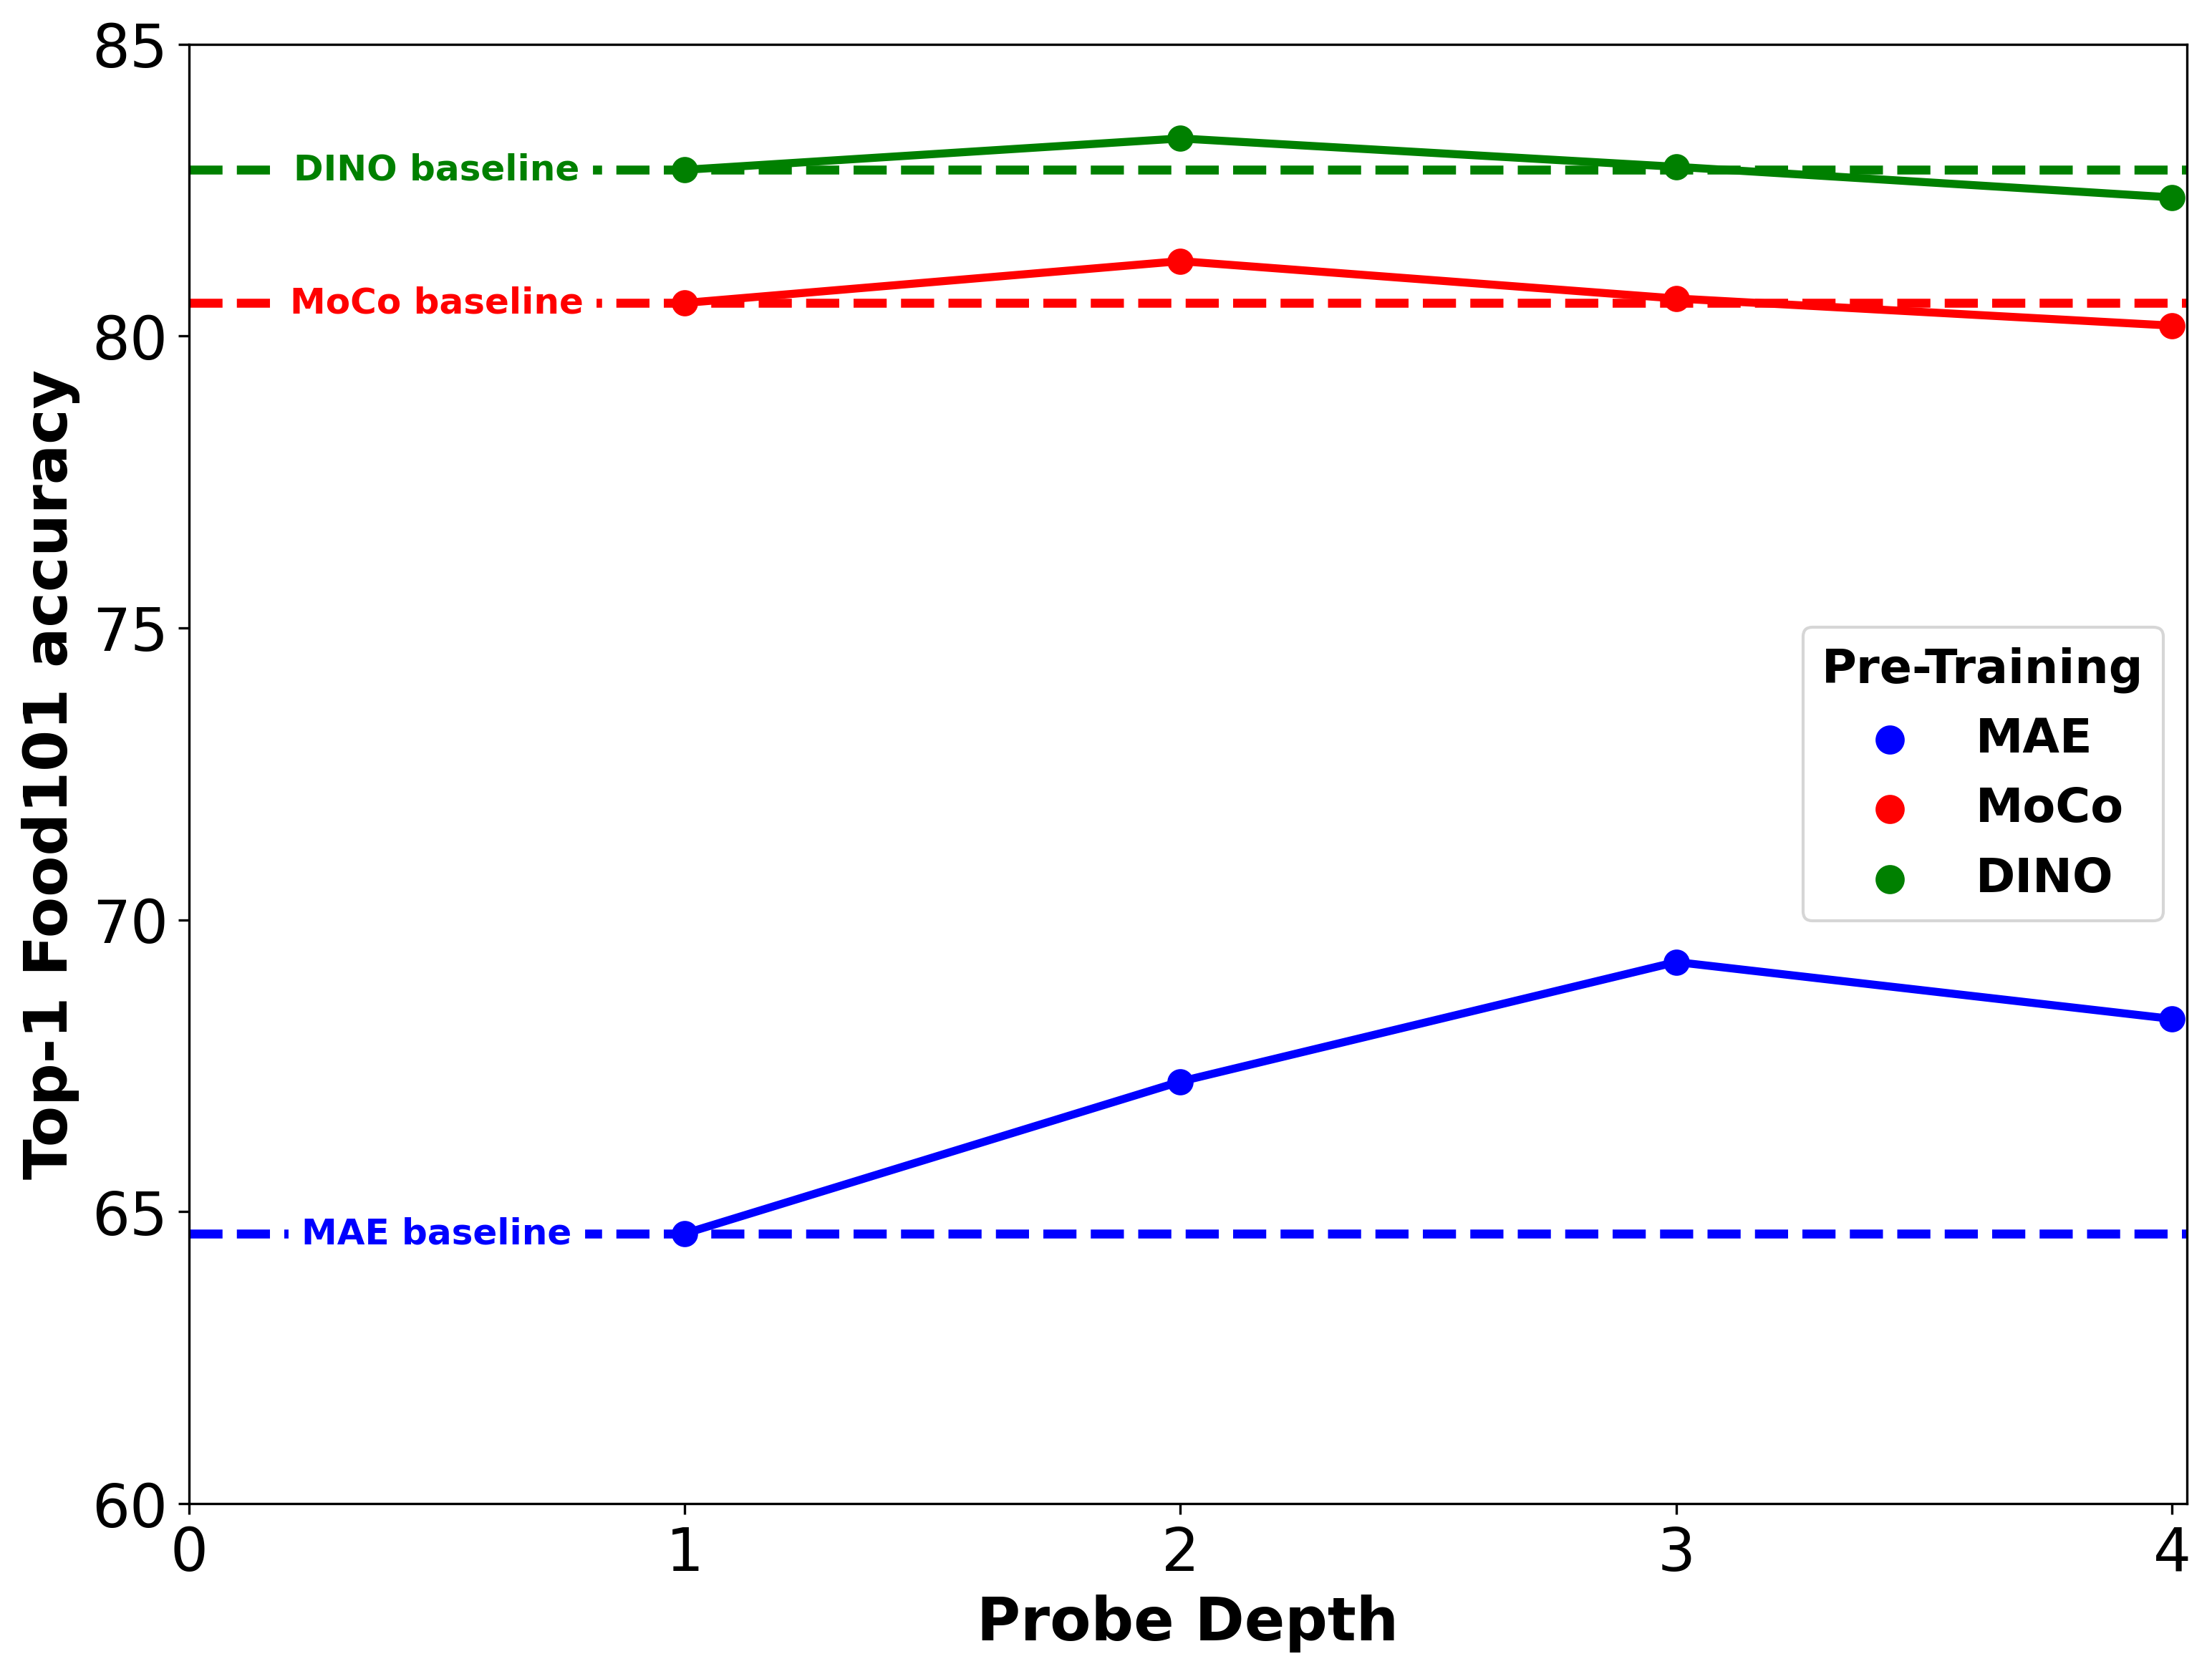

In [20]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

data = df[(df['Probe'].isin([1,2,3,4])) & (df['Model'].isin(['MAE','MoCo','DINO']))]
#sns.lineplot(data=data, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3, estimator='mean', ci='sd', err_style='bars')
data_2 = df_all[(df_all['Probe'].isin([1,2,3,4])) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]
sns.pointplot(data=data_2, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], errorbar="sd", capsize=.02)
#data_2.groupby('Probe')['Top-1'].agg([min, max]).plot(ax=ax)

plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')


ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 Food101 accuracy", fontweight="bold", fontsize = 20)

# hack because pointplot is shifted to left while lineplot is not
plt.xlim([-1, 3.03])
plt.ylim([60, 85])

ax.set_xticks(np.arange(-1, 4, 1), visible=True)
ax.set_yticks(np.arange(60, 86, 5), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(60, 86, 5)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16, 'weight':'bold'})
plt.setp(legend.get_title(),fontsize=16, fontweight='bold')
for legobj in legend.legendHandles:
    legobj.set_linewidth(3)

fig.savefig(fig_dir + 'food101_deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

In [23]:
resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}}
#datasets = ['Food101', 'FGVCAircraft']
#resultsp = {k:{d:{} for d in datasets} for k in resultsp.keys()}

for key in resultsp:
    folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/" #Food101/logs/" + key + '/vit_base_patch16/'

    log_files_list = []
    for root, dirs, files in os.walk(folder_name):
        if root[len(folder_name):].count(os.sep) < 10:
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)  
                    log_files_list.append(log_file)   

    for log_file in log_files_list:
        if key in log_file and 'FGVC' in log_file:            
            log_list = []
            print(log_file)
            if os.path.isfile(log_file): 
                with open(log_file, "r") as log:
                    for line in log:
                        log_dict = literal_eval(line)
                        log_list.append(log_dict)
                    
            df = pd.DataFrame(log_list)
            df = df.set_index('epoch')
            #print(log_file.split('/')[-4])
            try:
                if 'lin_' in log_file:
                    resultsp[key][log_file.split('/')[-3]][log_file.split('/')[-2]] = df
                else:
                    resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-2]] = df
            except KeyError:
                if 'lin_' in log_file:
                    resultsp[key][log_file.split('/')[-3]] = {}
                    resultsp[key][log_file.split('/')[-3]][log_file.split('/')[-2]] = df
                else:
                    resultsp[key][log_file.split('/')[-5]] = {}
                    resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-2]] = df

/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_1/12803845/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_1/12979675/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_1/12986762/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_2/12803846/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_2/12979676/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_2/12986763/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/FGVCAircraft/logs/MAE/vit_base_patch16/lin_3/12803847/log.txt
/checkpoint/sshkhr/experiments/ViT-analysis/neur

In [24]:
df= {}
df_all = {}
for model in resultsp:
    df[model] = {}
    df_all[model] = {}
    for intermediate in resultsp[model]:
        print(model, intermediate)
        top_1 = [resultsp[model][intermediate][exp]['test_acc1'].max() for exp in resultsp[model][intermediate]]
        best = sorted(top_1, reverse=True)[:5]
        if 'lin_' in intermediate:
            intermediate = int(intermediate.split('_')[1])
        df[model][intermediate] = np.mean(best)
        df_all[model][intermediate] = best

MAE lin_1
MAE lin_2
MAE lin_3
MAE lin_4
MAE blocks.0
MAE blocks.1
MAE blocks.2
MAE blocks.3
MAE blocks.4
MAE blocks.5
MAE blocks.6
MAE blocks.7
MAE blocks.8
MAE blocks.9
MAE blocks.10
MAE blocks.11
MAE all
MoCo lin_1
MoCo lin_2
MoCo lin_3
MoCo lin_4
MoCo blocks.0
MoCo blocks.1
MoCo blocks.2
MoCo blocks.3
MoCo blocks.4
MoCo blocks.5
MoCo blocks.6
MoCo blocks.7
MoCo blocks.8
MoCo blocks.9
MoCo blocks.10
MoCo blocks.11
MoCo all
DINO lin_1
DINO lin_2
DINO lin_3
DINO lin_4
DINO blocks.0
DINO blocks.1
DINO blocks.2
DINO blocks.3
DINO blocks.4
DINO blocks.5
DINO blocks.6
DINO blocks.7
DINO blocks.8
DINO blocks.9
DINO blocks.10
DINO blocks.11
DINO all


In [25]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe'}, inplace=True)
df = df.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df.dropna(inplace=True)

In [26]:
df_all = pd.DataFrame.from_dict(df_all)
df_all.reset_index(inplace=True)
df_all.rename(columns={'index':'Probe'}, inplace=True)
df_all = df_all.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df_all.dropna(inplace=True)
df_all = df_all.explode('Top-1')

In [28]:
fig_dir = '../figures/rebuttal/'

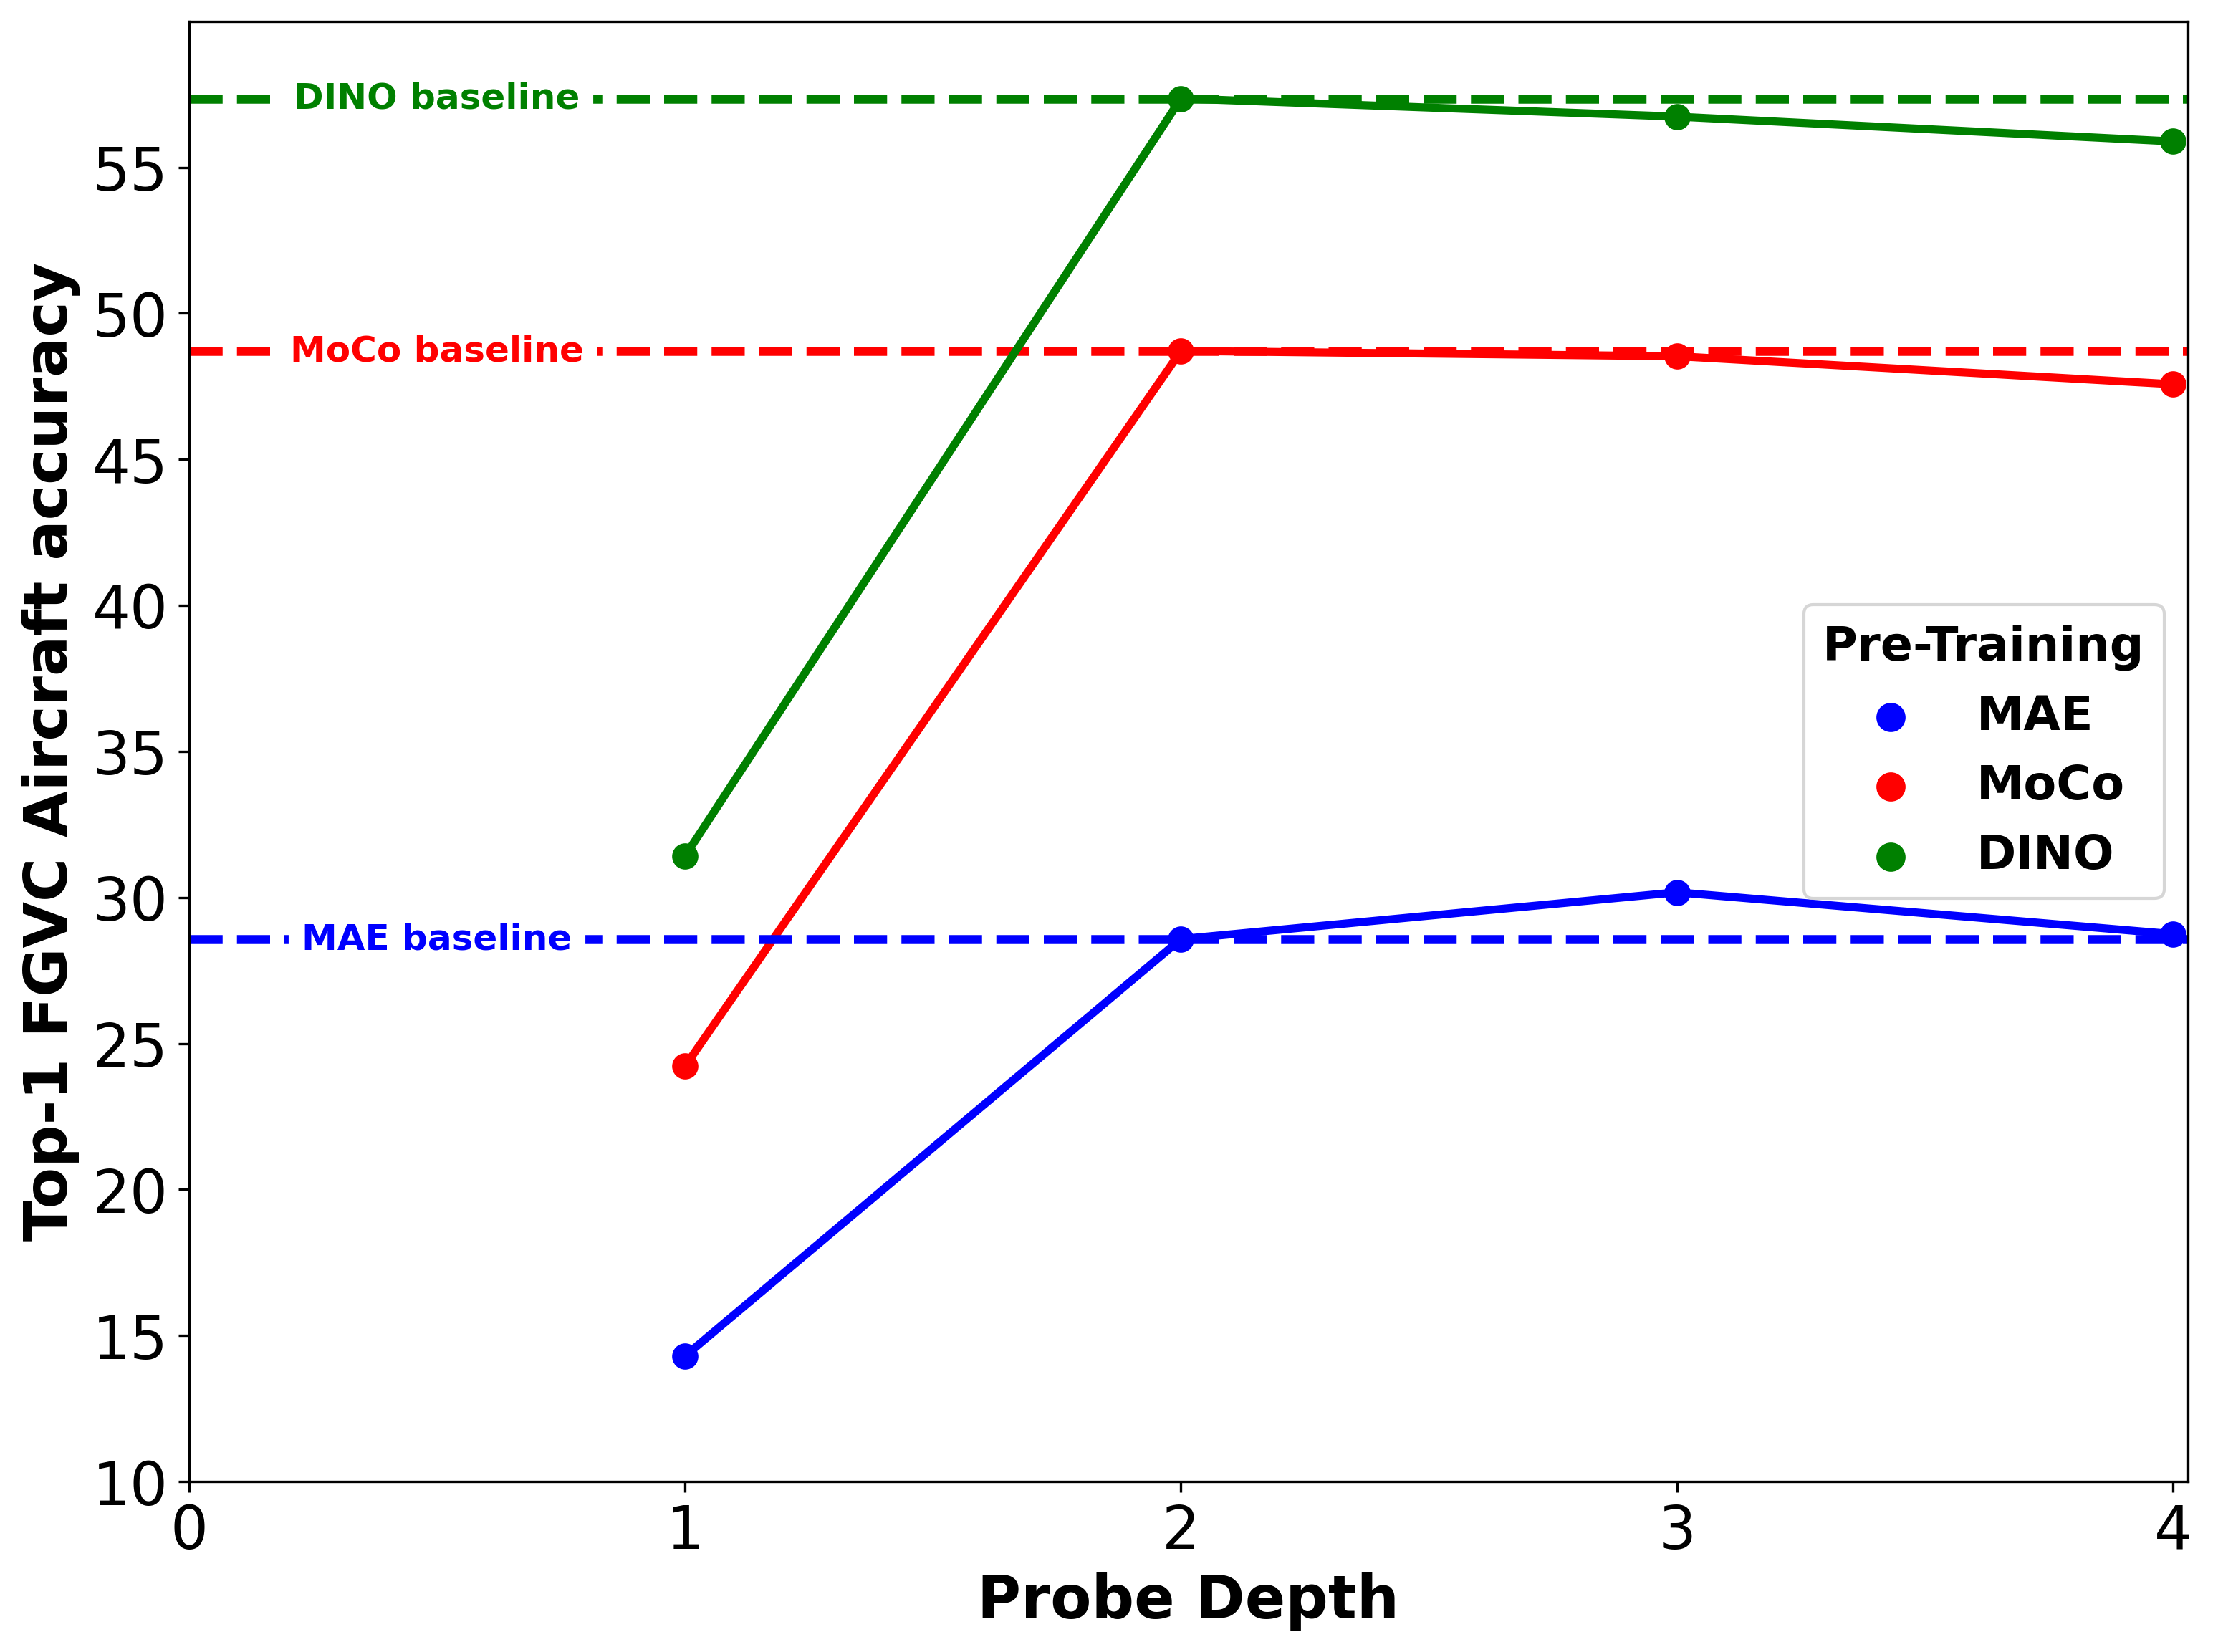

In [29]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

data = df[(df['Probe'].isin([1,2,3,4])) & (df['Model'].isin(['MAE','MoCo','DINO']))]
#sns.lineplot(data=data, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], linewidth = 3, estimator='mean', ci='sd', err_style='bars')
data_2 = df_all[(df_all['Probe'].isin([1,2,3,4])) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]
sns.pointplot(data=data_2, x='Probe', y='Top-1', hue='Model', marker="o", palette=['b', 'r', 'g'], errorbar="sd", capsize=.02)
#data_2.groupby('Probe')['Top-1'].agg([min, max]).plot(ax=ax)

plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 2)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MAE') & (df['Probe'] == 2)]['Top-1'].values[0]), 'MAE baseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 2)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 2)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 2)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(-0.5, (df[(df['Model'] == 'DINO') & (df['Probe'] == 2)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')


ax.set_xlabel("Probe Depth", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 FGVC Aircraft accuracy", fontweight="bold", fontsize = 20)

# hack because pointplot is shifted to left while lineplot is not
plt.xlim([-1, 3.03])
plt.ylim([10, 60])

ax.set_xticks(np.arange(-1, 4, 1), visible=True)
ax.set_yticks(np.arange(10, 60, 5), visible=True)
ax.set_xticklabels([x for x in np.arange(0, 5, 1)], fontsize = 20)
ax.set_yticklabels([x for x in np.arange(10, 60, 5)], fontsize = 20)

legend = plt.legend(loc=5, title="Pre-Training", prop={'size': 16, 'weight':'bold'})
plt.setp(legend.get_title(),fontsize=16, fontweight='bold')
for legobj in legend.legendHandles:
    legobj.set_linewidth(3)

fig.savefig(fig_dir + 'fgvcaircraft_deep_probes.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

### Intermediate probes eval

resultsp = {'MAE': {}, 'MoCo': {}, 'DINO': {}}

for key in resultsp:
    folder_name = "/checkpoint/sshkhr/experiments/ViT-analysis/neurips_rebuttal/fine-grained/multi_linprob/FGVCAircraft/logs/" + key + '/vit_base_patch16/'

    log_files_list = []
    for root, dirs, files in os.walk(folder_name):
        if root[len(folder_name):].count(os.sep) < 4:
            for file in files:
                if file == 'log.txt':
                    log_file = os.path.join(root, file)  
                    log_files_list.append(log_file)   

    for log_file in log_files_list:            
        log_list = []
        print(log_file)
        if os.path.isfile(log_file): 
            with open(log_file, "r") as log:
                for line in log:
                    log_dict = literal_eval(line)
                    log_list.append(log_dict)
                
        df = pd.DataFrame(log_list)
        df = df.set_index('epoch')
        #print(log_file.split('/')[-4])
        try:
            resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-3]] = df
        except KeyError:
            resultsp[key][log_file.split('/')[-5]] = {}
            resultsp[key][log_file.split('/')[-5]][log_file.split('/')[-3]] = df

In [40]:
df= {}
df_all = {}
for model in resultsp:
    df[model] = {}
    df_all[model] = {}
    for intermediate in resultsp[model]:
        #print(model, intermediate)
        top_1 = [resultsp[model][intermediate][exp]['test_acc1'].max() for exp in resultsp[model][intermediate]]
        best = sorted(top_1, reverse=True)[:5]
        df[model][intermediate] = np.mean(best)
        df_all[model][intermediate] = best

In [41]:
df = pd.DataFrame.from_dict(df)
df.reset_index(inplace=True)
df.rename(columns={'index':'Probe'}, inplace=True)
df = df.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df.dropna(inplace=True)

In [42]:
df_all = pd.DataFrame.from_dict(df_all)
df_all.reset_index(inplace=True)
df_all.rename(columns={'index':'Probe'}, inplace=True)
df_all = df_all.melt(id_vars=['Probe'], value_name='Top-1', var_name='Model')
df_all.dropna(inplace=True)
df_all = df_all.explode('Top-1')

In [33]:
cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]
grouped = data_2.groupby(['Model', 'Probe'])
grouped.agg(['mean', 'std'])

Top-1          
                      mean       std
Model Probe                         
DINO  1          31.414868  0.000000
      all        44.364508  0.000000
      blocks.0   31.954437  0.000000
      blocks.1   31.594724  0.000000
      blocks.10  42.775779  0.000000
      blocks.11  41.696643  0.000000
      blocks.2   32.014389  0.000000
      blocks.3   34.232614  0.000000
      blocks.4   35.881295  0.000000
      blocks.5   36.211031  0.000000
      blocks.6   38.609113  0.000000
      blocks.7   40.347722  0.000000
      blocks.8   42.885692  0.017307
      blocks.9   43.585132  0.000000
MAE   1          14.298561  0.000000
      all        24.010791  0.000000
      blocks.0   16.456835  0.000000
      blocks.1   17.985612  0.000000
      blocks.10  21.822542  0.000000
      blocks.11  21.193046  0.000000
      blocks.2   18.435252  0.000000
      blocks.3   18.824940  0.000000
      blocks.4   18.974820  0.000000
      blocks.5   18.864908  0.017307
      blocks.6   19.154676  0.000000
      blocks.7   19.154676  0.000000
      blocks.8   21.612710  0.000000
      blocks.9   22.182254  0.000000
MoCo  1          24.220624  0.000000
      all        36.300959  0.000000
      blocks.0   24.070743  0.000000
      blocks.1   24.520384  0.000000
      blocks.10  33.932854  0.000000
      blocks.11  32.344125  0.000000
      blocks.2   25.139888  0.017307
      blocks.3   26.448841  0.017307
      blocks.4   28.836931  0.000000
      blocks.5   30.305755  0.000000
      blocks.6   29.856115  0.000000
      blocks.7   31.514788  0.017307
      blocks.8   33.063549  0.000000
      blocks.9   34.772182  0.000000

/tmp/ipykernel_1161817/3348563273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({1:'None', 'all':'All'}, inplace=True)
/tmp/ipykernel_1161817/3348563273.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2.replace({1:'None', 'all':'All'}, inplace=True)


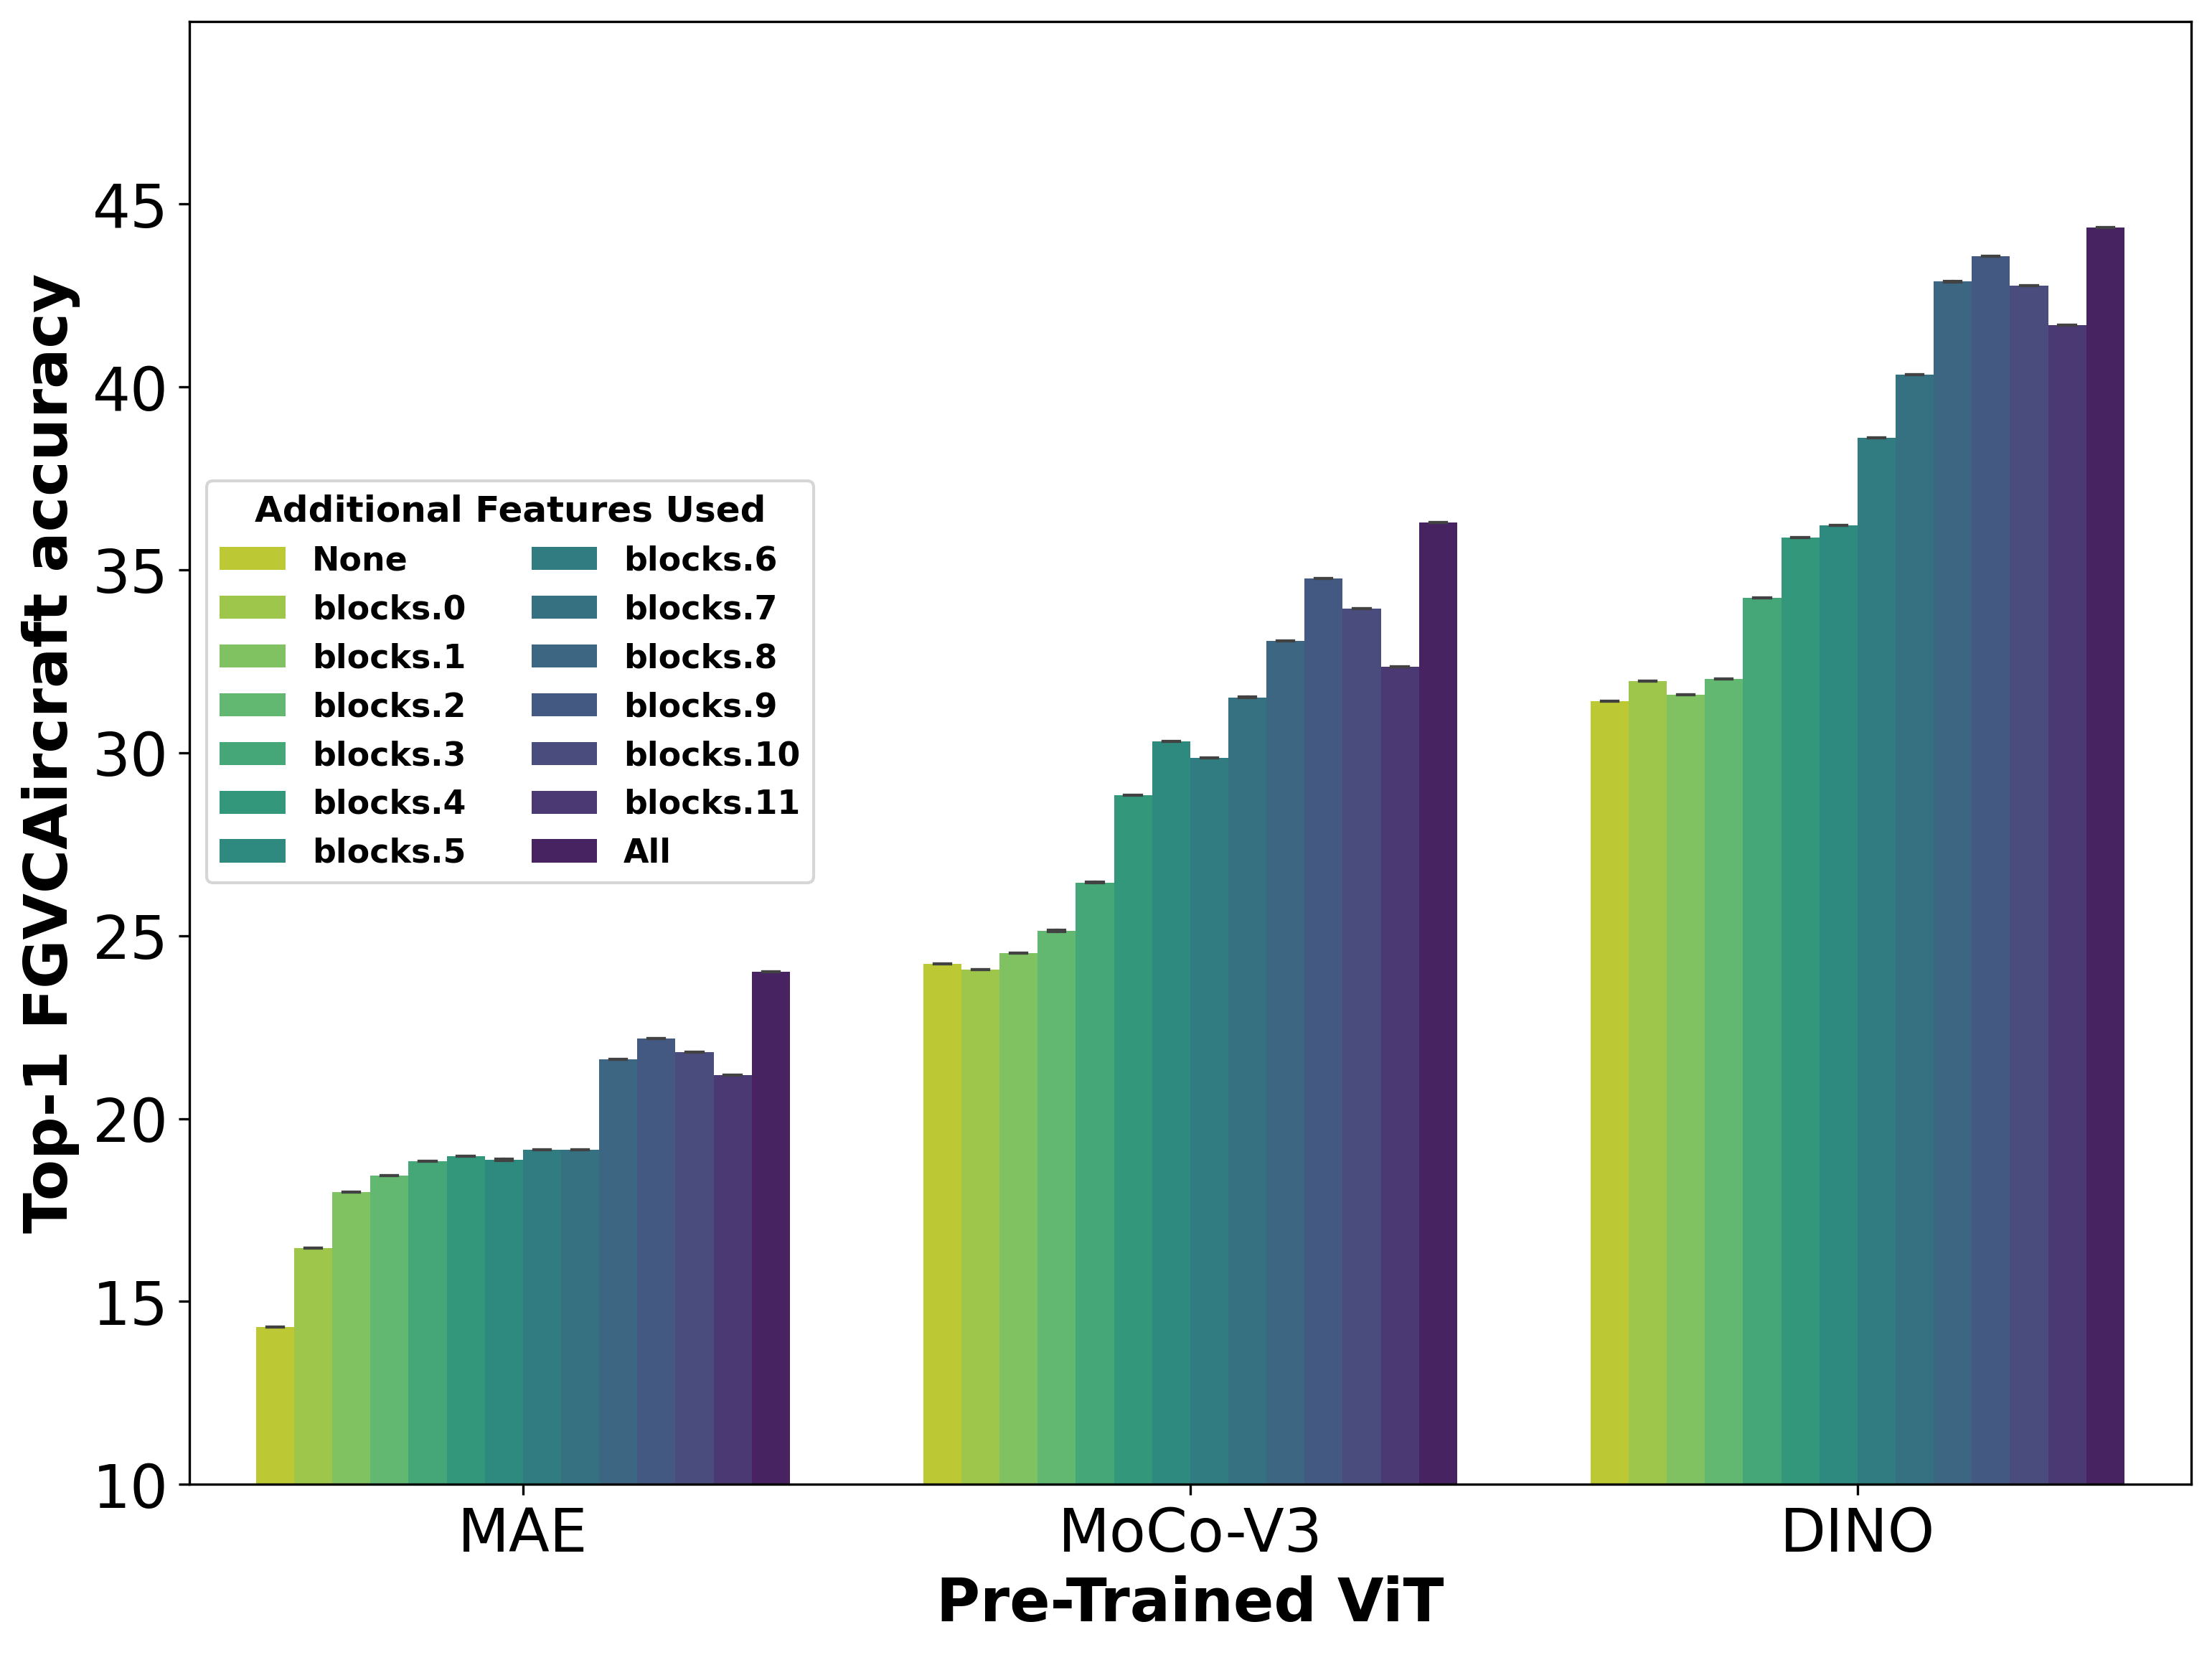

In [34]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data = df[(df['Probe'].isin(cols)) & (df['Model'].isin(['MAE','MoCo','DINO']))]

data.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]

data_2.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

plot = sns.barplot(data=data_2, x='Model', y='Top-1', hue='Probe', hue_order = hue_order, palette=reversed(sns.color_palette("viridis", 14)), errwidth=1, capsize=0.025)

'''
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.53, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE\n\nbaseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')
'''

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 FGVCAircraft accuracy", fontweight="bold", fontsize = 20)

plt.ylim([10, 50])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(10, 46, 5), visible=True)
ax.set_yticklabels([x for x in np.arange(10, 46, 5)], fontsize = 20)

legend = plt.legend(loc='best', title="Additional Features Used", prop={'size': 11, 'weight':'bold'}, ncol=2, bbox_to_anchor=(.32, .4))
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'fgvcaircraft_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 

/tmp/ipykernel_1161817/2842584922.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.replace({1:'None', 'all':'All'}, inplace=True)
/tmp/ipykernel_1161817/2842584922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2.replace({1:'None', 'all':'All'}, inplace=True)


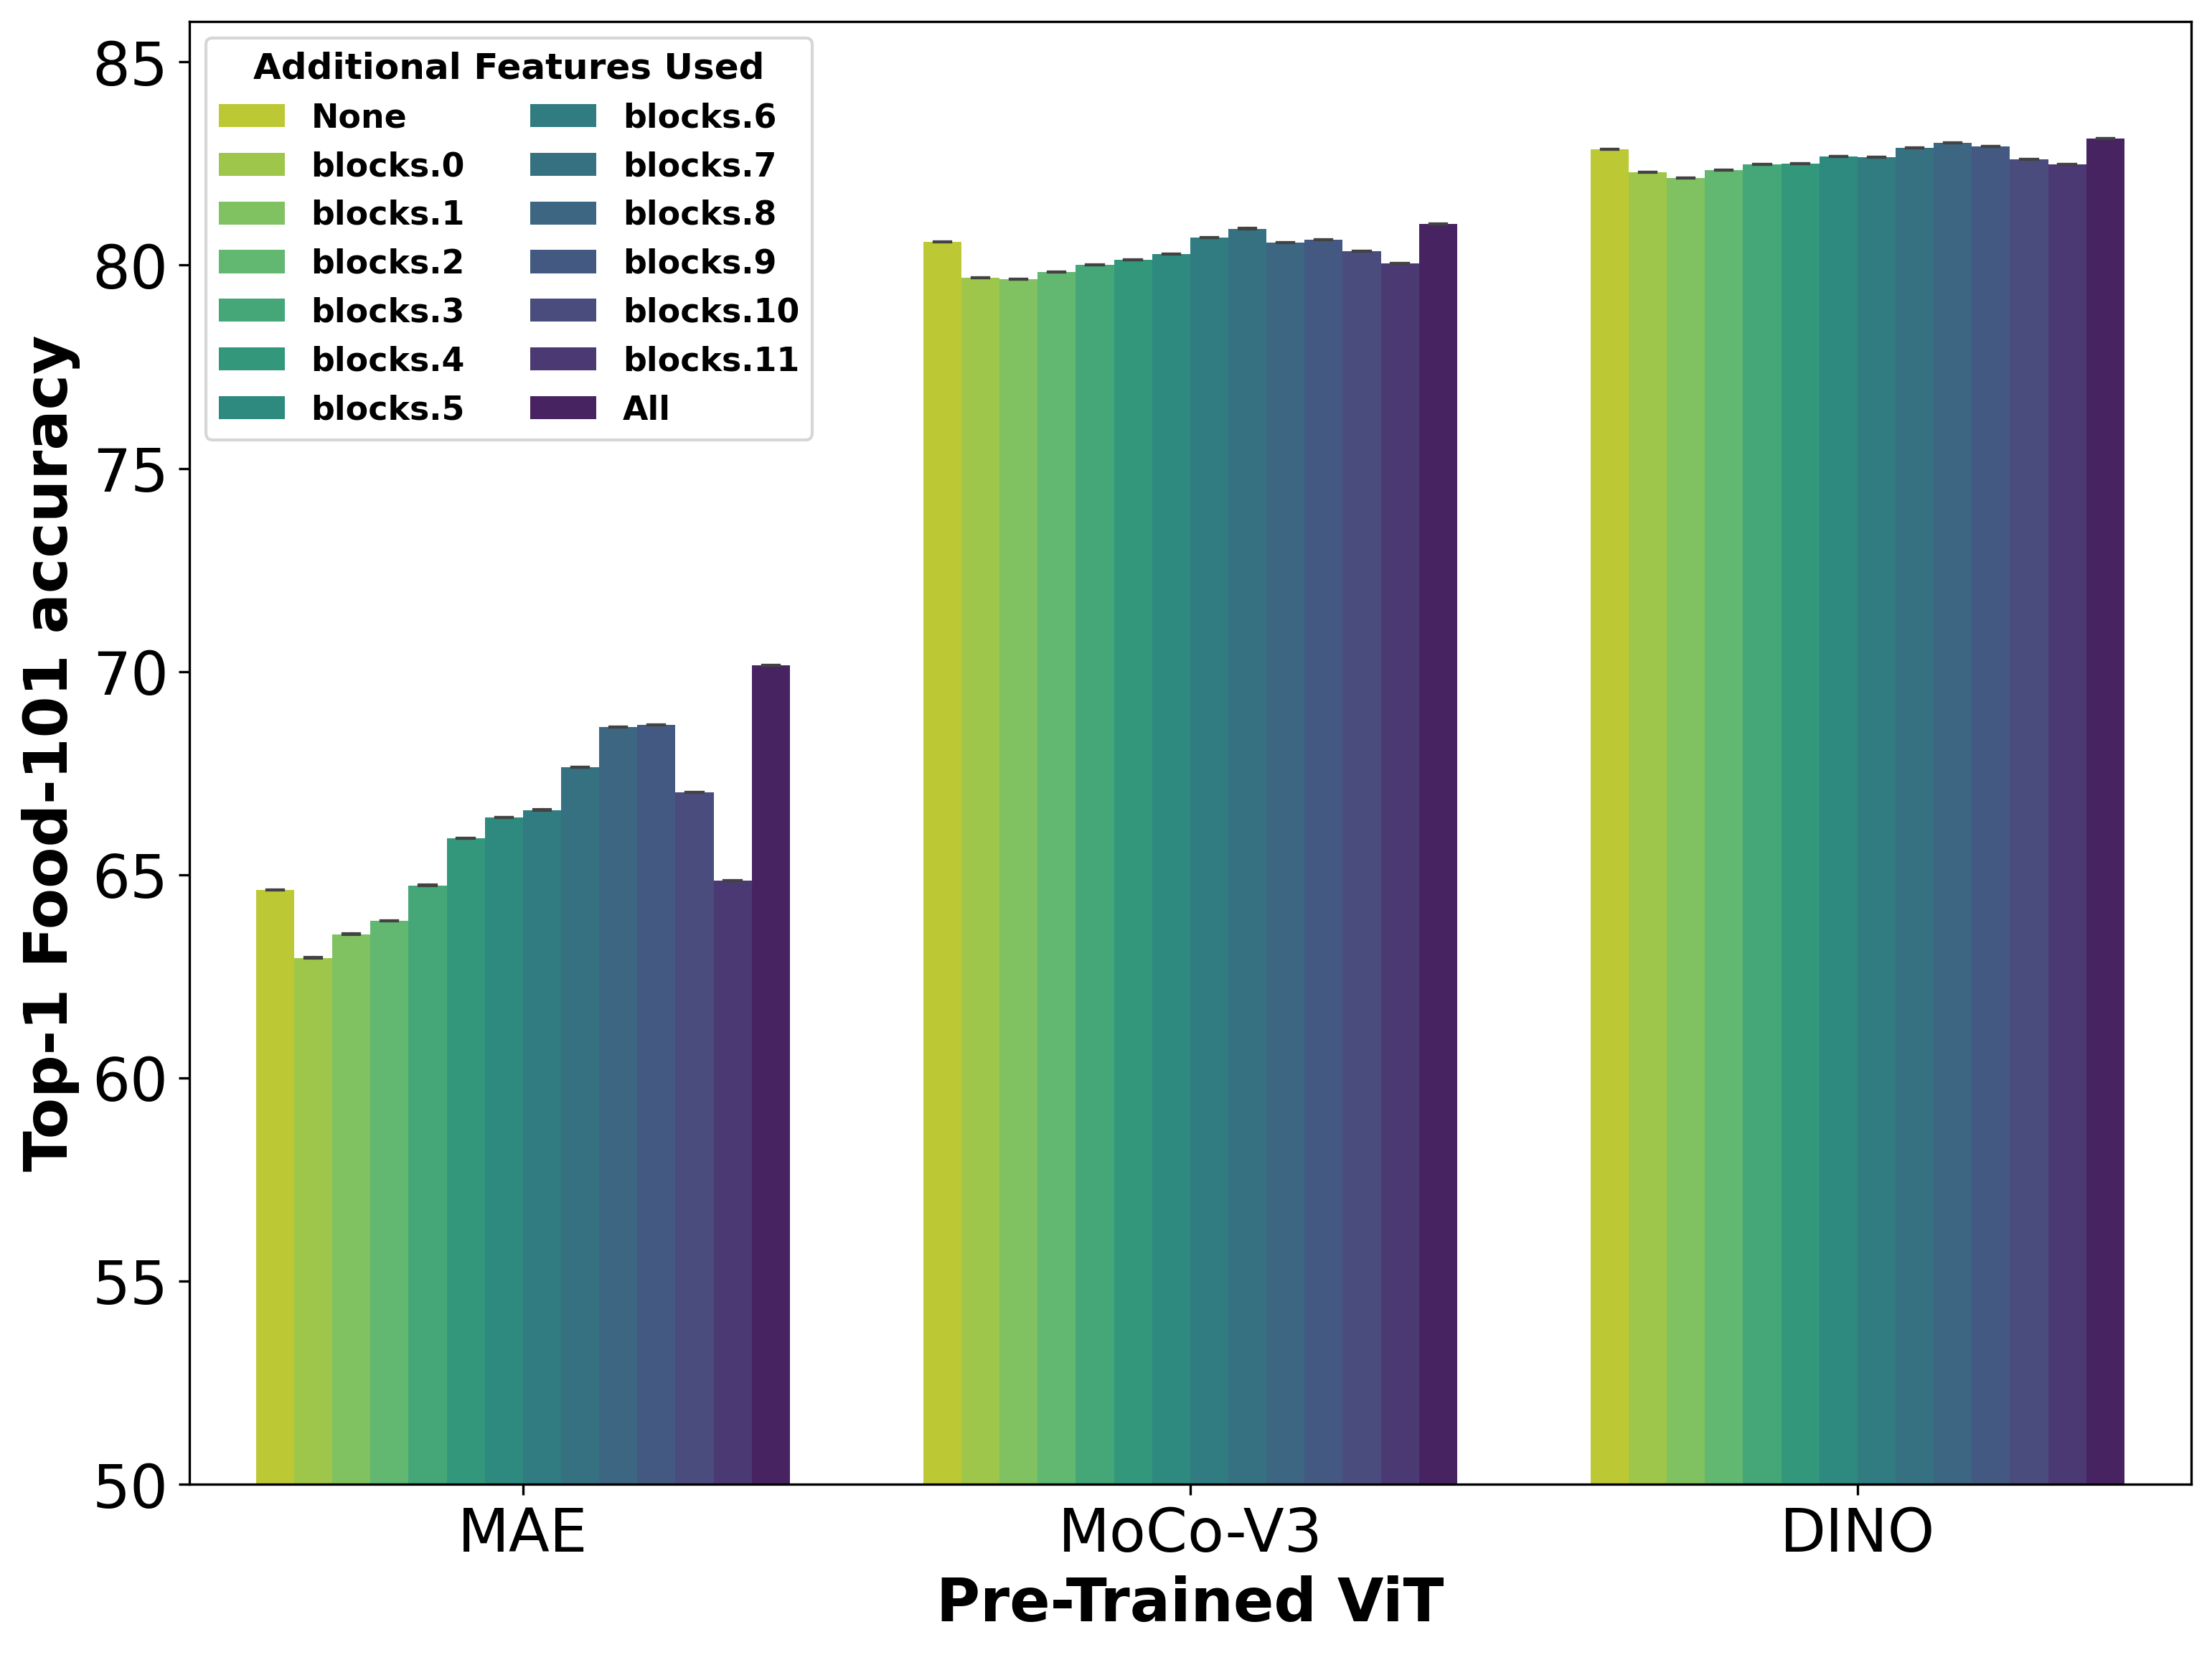

In [46]:
fig, ax = plt.subplots(figsize=(12, 9), dpi=300, sharex=True)

cols = [1] + ['blocks.'+str(i) for i in range(12)] + ['all']
data = df[(df['Probe'].isin(cols)) & (df['Model'].isin(['MAE','MoCo','DINO']))]

data.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

data_2 = df_all[(df_all['Probe'].isin(cols)) & (df_all['Model'].isin(['MAE','MoCo','DINO']))]

data_2.replace({1:'None', 'all':'All'}, inplace=True)
hue_order = ['None'] + ['blocks.'+str(i) for i in range(12)] + ['All']

plot = sns.barplot(data=data_2, x='Model', y='Top-1', hue='Probe', hue_order = hue_order, palette=reversed(sns.color_palette("viridis", 14)), errwidth=1, capsize=0.025)

'''
plt.axhline(y=(df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), c='b', linestyle='--', linewidth = 3)
plt.text(0.53, (df[(df['Model'] == 'MAE') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MAE\n\nbaseline', fontsize=12, fontweight="bold", c='b', va='center', ha='center', backgroundcolor='none')
plt.axhline(y=(df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), c='r', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'MoCo') & (df['Probe'] == 1)]['Top-1'].values[0]), 'MoCo baseline', fontsize=12, c='r', fontweight="bold", va='center', ha='center', backgroundcolor='w')
plt.axhline(y=(df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), c='g', linestyle='--', linewidth = 3)
plt.text(0.3, (df[(df['Model'] == 'DINO') & (df['Probe'] == 1)]['Top-1'].values[0]), 'DINO baseline', fontsize=12, c='g', fontweight="bold", va='center', ha='center', backgroundcolor='w')
'''

ax.set_xlabel("Pre-Trained ViT", fontweight="bold", fontsize = 20)
ax.set_ylabel("Top-1 Food-101 accuracy", fontweight="bold", fontsize = 20)

plt.ylim([50, 86])

ax.set_xticklabels(['MAE', 'MoCo-V3', 'DINO'], fontsize = 20)
ax.set_yticks(np.arange(50, 86, 5), visible=True)
ax.set_yticklabels([x for x in np.arange(50, 86, 5)], fontsize = 20)

legend = plt.legend(loc='upper left', title="Additional Features Used", prop={'size': 11, 'weight':'bold'}, ncol=2)#, bbox_to_anchor=(.32, .4))
plt.setp(legend.get_title(),fontsize=12, fontweight='bold')

fig.savefig(fig_dir + 'food101_marginal_features.pdf', dpi=500, bbox_inches = "tight")
plt.show() 